[![session-9](https://github.com/semilleroCV/Hands-on-Computer-Vision/blob/main/sesiones/sesion9/Sesion9-banner.png?raw=1)](https://github.com/semilleroCV/Hands-on-Computer-Vision/tree/main/Sesiones/Sesion9)

In [1]:
#@title **load required libraries**
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from matplotlib.colors import ListedColormap, BoundaryNorm

In [2]:
%%capture
#@title clone our repo to get data 'locally'
! git clone -n --depth=1 --filter=tree:0 \
  https://github.com/semilleroCV/Hands-on-Computer-Vision
%cd Hands-on-Computer-Vision
! git sparse-checkout set --no-cone sesiones/sesion9
! git checkout
%cd sesiones/sesion9/

# <font color="EB9A54"><center> **Hands-On Sesión 9: Pre-Thermal Imaging 📚🌡️** </center></font>

## <font color='#4C5FDA'> **Contenido**</font>

[**1. Cargamos los datos de una zona**](#tema1)

[**2. Generar la imagen térmica**](#tema2)

[**3. Generar atenuación**](#tema3)

[**4. Intensidad de la escena**](#tema4)

[**5. Lectura del sensor**](#tema5)

# <font color="4C5FDA"> **Cargamos los datos de una zona** </font><a name="tema1"></a>
### <font color="4C5FDA"> **Visualización de Materiales y sus Firmas Espectrales** </font>🔍

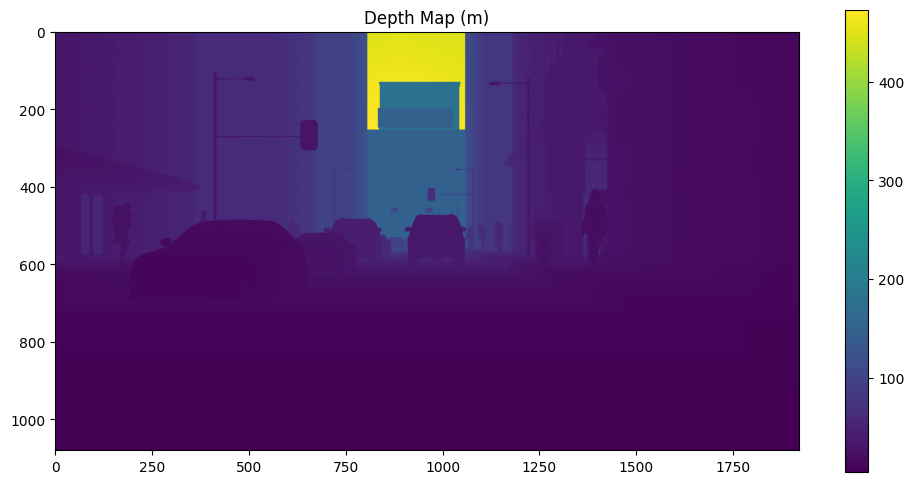

In [3]:
depth_map = np.load('data/Depth_L_0001.npy')
plt.figure(figsize=(12, 6))
plt.title('Depth Map (m)')
plt.imshow(depth_map)
plt.colorbar()
plt.show()

### <font color="4C5FDA"> **Cargamos las Temperaturas de la Escena** </font>🌡️

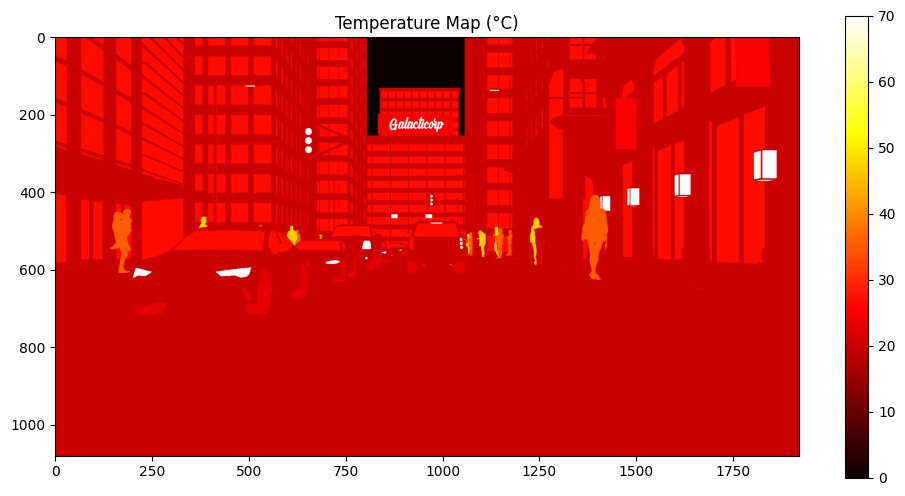

In [4]:
temperature_map = np.load('data/tMap_L_0001.npy')
plt.figure(figsize=(12, 6))
plt.title('Temperature Map (°C)')
plt.imshow(temperature_map, cmap='hot')
plt.colorbar()
plt.show()

### <font color="4C5FDA"> **Cargamos la base de datos de firmas espectrales para diferentes materiales** </font>📂

In [5]:
eList = np.load('data/eList.npy', allow_pickle=True).item()["eList"]
# lista de indices de nombres y firmas de emisividad

dataBaseName = np.load('data/matName_FullDatabase.npy', allow_pickle=True).item()["matName"]
dataBaseName = dataBaseName.squeeze()
dataBaseName = np.hstack(dataBaseName) # lista de nombres de los materiales

dataBaseLib = np.load('data/matLib_FullDatabase.npy', allow_pickle=True).item()["matLib"]
dataBaseLib = dataBaseLib[::-1, :] # Reverso el orden de la base de datos
# firmas de emisividad para cada material

emissivity_map_list_index = np.load('data/eMap_L_0001.npy')
# reprecenta los indices de la lista de indices de nombres y firmas de emisividad

emissivity_map_material_index = eList[emissivity_map_list_index-1].squeeze()
# se convierten los indices de la lista a indices de materiales

emissivity_map = dataBaseLib[:, emissivity_map_material_index - 1]
# se convierten los indices de materiales a firmas de emisividad


### <font color="4C5FDA"> **Visualización de Materiales** </font>🔍


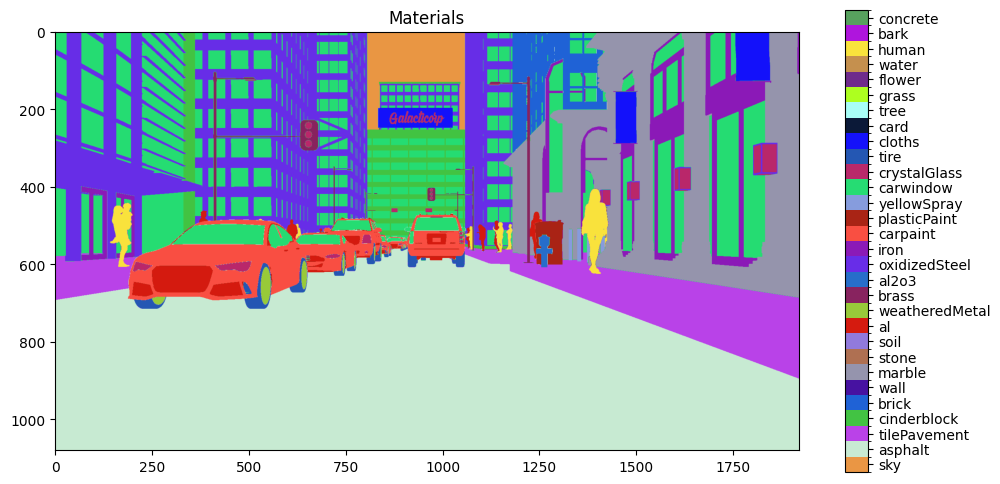

In [6]:
n = dataBaseName.shape[0] # numero de materiales

np.random.seed(314)
colors = np.random.rand(n, 3)

cmap = ListedColormap(colors)

norm = BoundaryNorm(boundaries=np.arange(1, n+2)-0.5, ncolors=n, clip=True)

plt.figure(figsize=(12, 6))
plt.title('Materials')
im = plt.imshow(emissivity_map_material_index, cmap=cmap, norm=norm)
cbar = plt.colorbar(im, ticks=np.arange(1, n+1))
cbar.ax.set_yticklabels(dataBaseName)
plt.show()


## <font color='#ECA702'>**<font color="#FF0000">R</font><font color="#FF7F00">e</font><font color="#FFFF00">t</font><font color="#00FF00">o</font> #<font color="#0000FF">1</font>** 💪</font>  

### <font color="4C5FDA">**Escoge un pixel y visualiza su firma espectral**</font> 🔍


(49, 1080, 1920)


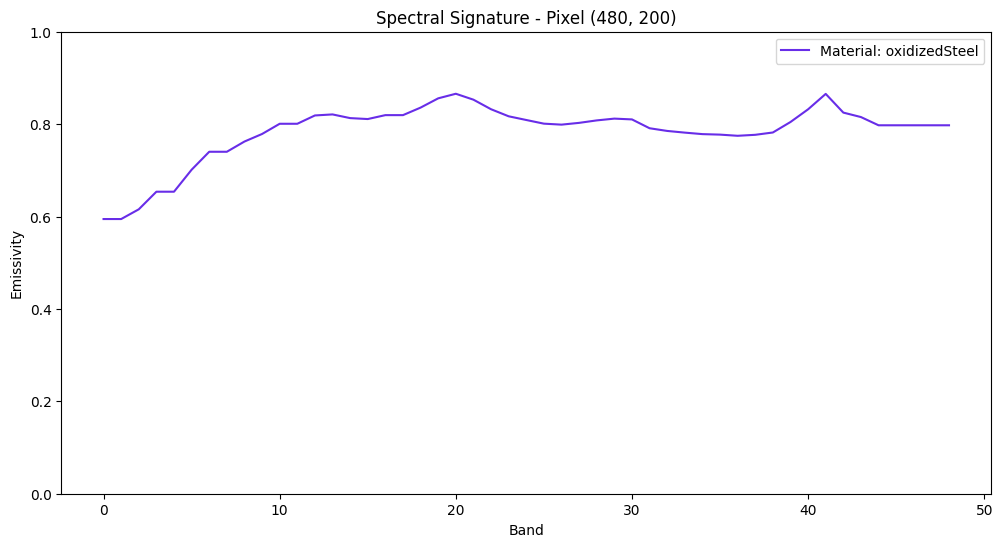

In [7]:
## Escoge un pixel de la imagen para ver su firma espectral
pixelX = 480
pixelY = 200

print(emissivity_map.shape) # dimensiones del mapa de emisividad

map_pixel = emissivity_map[:, pixelY, pixelX] # firma espectral del pixel
material_index = emissivity_map_material_index[pixelY, pixelX] # indice del material
material_name = dataBaseName[material_index-1] # nombre del material

plt.figure(figsize=(12, 6))
plt.title('Spectral Signature - Pixel ({}, {})'.format(pixelX, pixelY))
plt.plot(map_pixel, color=colors[material_index-1], label='Material: {}'.format(material_name))
plt.xlabel('Band')
plt.ylabel('Emissivity')
plt.ylim(0, 1)
plt.legend()
plt.show()


# <font color="4C5FDA"> **Generar la imagen térmica** </font><a name="tema2"></a>

## <font color='#ECA702'><font color="#FF0000">R</font><font color="#FF7F00">e</font><font color="#FFFF00">t</font><font color="#00FF00">o</font> #<font color="#0000FF">2</font> 💪</font>

### <font color="4C5FDA"> **Generar atenuación** </font><a name="tema3"></a>

Las ondas de luz que emiten los objetos en una escena son **atenuadas** por el aire. El siguiente código, carga unos datos que tienen la 'cantidad' que **atenua** el aire en varias longitudes de onda.

In [8]:
def get_attenuation(lambda_start, lambda_stop, bands=49, attenuation_file="air"):

  """
  Esta función nos entrega las longitudes de onda con su valor de
  atenuación en un rango del espectro determinado (lambda_start a lambda_stop)
  y el número de bandas espectrales que se desean (default: 49).
  """
  file="data/"+attenuation_file+".txt"

  trans_array = np.loadtxt(file)

  # Tomar indices
  start_index = np.where(trans_array[:,0] == lambda_start)[0][0]
  stop_index = np.where(trans_array[:,0] == lambda_stop )[0][0]

  trans_index = np.arange(start_index, stop_index)

  # Extraer las longitudes de onda y la atenuación del vector
  wavelength = trans_array[trans_index,0]
  transmittance = trans_array[trans_index,1]
  attenuation = trans_array[trans_index,2]

  # Reducimos todas los datos en ese rango a solo el número de bandas
  # que se desean (default: 49)
  wavelength = wavelength[np.linspace(0 ,len(wavelength) - 1, bands, dtype=int)]
  attenuation = attenuation[np.linspace(0 ,len(wavelength) - 1, bands, dtype=int)]
  transmittance = transmittance[np.linspace(0 ,len(wavelength) - 1, bands, dtype=int)]

  return wavelength, transmittance, attenuation

#### Juega con los valores del archivo de atenuacion y visualiza

The attenuation vector has 49 samples


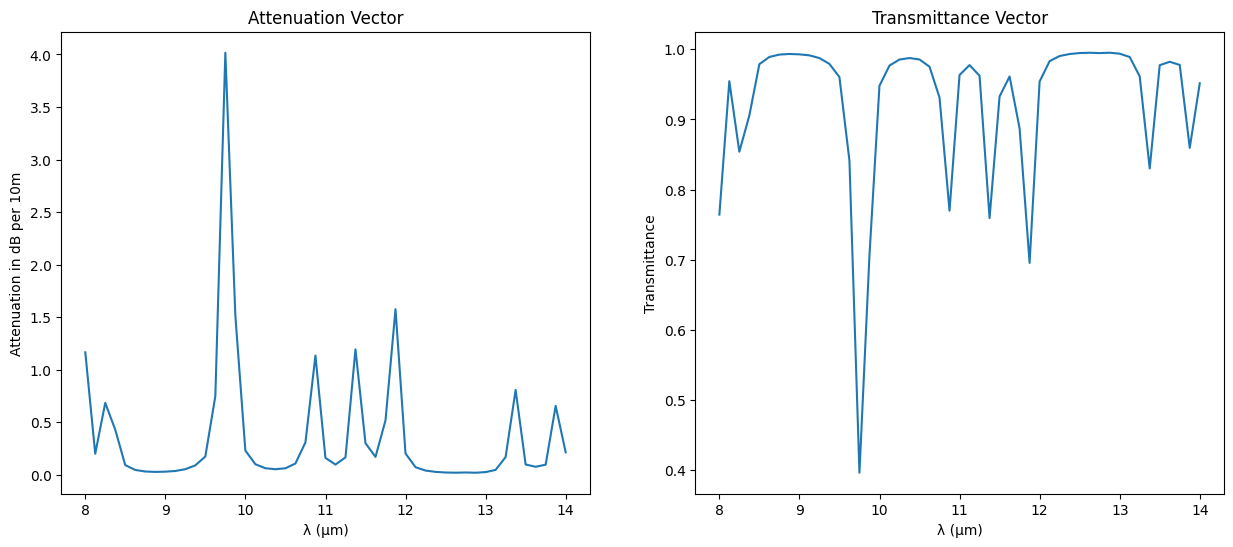

In [14]:
#Ajustando los parametros del problema

lambda_start = 8 # Lambda se encuentra en micrometros
lambda_stop= 14 # Lambda se encuentra en micrometros

# files attenuation:
# air
# enclosure
# CH4
# CO2
# H2O
# O3
wavelength, transmittance, attenuation  = get_attenuation(lambda_start, lambda_stop, attenuation_file='CH4')
print(f'The attenuation vector has {attenuation.shape[0]} samples')

plt.figure(figsize=(15,6))

# Graficamos la atenuación
plt.subplot(1, 2, 1)
plt.plot(wavelength, attenuation)
plt.title('Attenuation Vector')
plt.xlabel('λ (μm)')
plt.ylabel('Attenuation in dB per 10m')

# Graficamos la transmitancia
plt.subplot(1, 2, 2)
plt.plot(wavelength, transmittance)
plt.title('Transmittance Vector')
plt.xlabel('λ (μm)')
plt.ylabel('Transmittance')

plt.show()

# <font color="4C5FDA"> **Intensidad de la escena** </font><a name="tema4"></a>

Ahora que tenemos los datos (`Data`) de **intensidad** para una imagen en 64 canales y además lo que **atenua** el aire en esos 64 canales podemos determinar la intensidad teórica que **emite** un determinado pixel en una escena.

Pero una cosa... Si el aire **atenua** las ondas de la escena, eso significa que está **absorbiendo** y si **absorbe** energía la tiene que **emitir**.

$$
L_{\text {air }}(\lambda)=(1-\tau(\lambda)) B\left(\lambda ; T_{\text {air }}\right)
$$

Básicamente, la intensidad teórica que **emite** un objeto será lo que **emite** el objeto en sí sumado con lo que **emite el aire**:

$$
L_{\mathrm{obs}}(\lambda)=L_{\mathrm{obj}}(\lambda)+L_{\mathrm{air}}(\lambda)
$$

Y lo que emite el objeto es lo siguiente:

$$
L_{\mathrm{obj}}(\lambda) = \tau(\lambda) E(\lambda) B(\lambda ; T_{scene})
$$

La **transmitancia** viene dada por:

$$
\tau(\lambda ; d)=10^{-\alpha(\lambda) d / 10}
$$

donde $\alpha(\lambda)$ es el coeficiente de **atenuación** en función de la longitud de onda, en unidades de dB/m.

Reemplazando y factorizando $\tau(\lambda)$ podemos calcular la intensidad de la escena:

$$
I( \vec{x}, \lambda) = 10^{-attenuation(\lambda)d(\vec{x})/10}[E(\vec{x}, \lambda) L(\vec{x},T_{scene}, \lambda) - L(\vec{x}, T_{air}, \lambda)] + L(\vec{x}, T_{air}, \lambda)
$$

Donde $E(\vec{x},\lambda)$ representa la emisividad del pixel en un canal. $L(\vec{x},T, \lambda)$ son los fotones por segundo emitidos por un cuerpo negro a una determinada temperatura. Aquí asumimos que la radiación que llega a cada pixel es producida por **un solo objeto** (y el aire).

In [ ]:
from scipy.constants import h, c, k

# h: Constante de Planck
# c: Velocidad de la luz en el vacío
# k: Constante de Boltzmann

def blackbody(lambda_vals: np.array, T: float) -> np.array:
    """
    Calculate blackbody radiance.

    Parameters:
    lambda_vals (np.array): Wavelengths in micrometers.
    T (float or np.array): Temperature in Kelvin. Can be a scalar or 1D array.

    Returns:
    np.array: Spectral radiance with shape (len(T), len(lambda_vals)) if T is an array,
              otherwise shape (len(lambda_vals),).
    """
    # Convert lambda_vals to meters
    lambda_vals = np.array(lambda_vals) * 1e-6  # shape (N,)

    # Ensure T is a numpy array
    T = np.array(T)

    # If T is an array, reshape for broadcasting
    if T.ndim == 2:
        T = T[None, :]  # shape (M,1), where M is len(T)
        lamb = lambda_vals[:, None, None]  # shape (1,N)
    else:
        # T is scalar or already broadcastable
        lamb = lambda_vals

    # Compute the exponent term with proper broadcasting: shape (M,N) if T is an array
    exponent = h * c / (lamb * k * T)
    radiance = (2 * h * c**2) / (lamb**5) / (np.exp(exponent) - 1)

    # Convert radiance from W/m²/sr/m to μW/cm²/sr/μm
    radiance = radiance * 1e-4

    # If the original T was a scalar, remove the extra dimension.
    if radiance.shape[0] == 1:
        return radiance[0]

    return radiance

In [ ]:
def forward_model(lambda_start, lambda_stop, T_air, depth, T_scene, emissivity, attenuation_file="air"):

  """
  Esta función simula la propagación  la luz que llega a la apertura
  de una cámara térmica que emite una escena.

  propagación de la luz emitidad por una escena a través de la atmosfera
  """

  wavelength, _ ,attenuation = get_attenuation(lambda_start, lambda_stop, attenuation_file=attenuation_file)

  # Calcular la radiación de los cuerpos
  L_air = blackbody(wavelength, T_air)
  L_scene = blackbody(wavelength, T_scene)

  if depth.ndim == 2:
    depth = depth[None, :] # shape (1, H, W)
    attenuation = attenuation[:, None, None]  # shape (N,1,1)
    L_air = L_air[:, None, None]  # shape (N,1,1)


  transmittance = 10**(-attenuation*depth/10)

  # Calcular la luz en la apertura basado en el modelo anterior
  light_on_aperture = transmittance*(emissivity*L_scene-L_air) + L_air


  return light_on_aperture

## <font color='#ECA702'>**<font color="#FF0000">R</font><font color="#FF7F00">e</font><font color="#FFFF00">t</font><font color="#00FF00">o</font> #<font color="#0000FF">3</font>** 💪</font>  

Asigna una temperatura al ambiente, calcula la intensidad y grafique las dos curvas envolventes de un pixel.

**Nota**: Tenga en cuenta los parámetros de la funciones `forward` y `blackbody`.

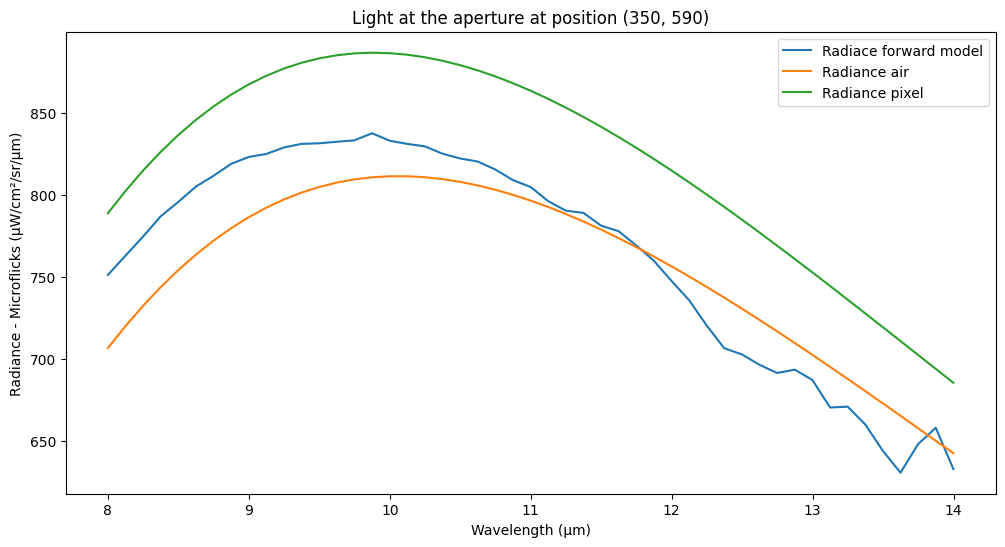

In [ ]:
### Escoge un pixel de la imagen
pixelX = 350
pixelY = 500


T_air = 290 # temperatura del aire
T_scene = temperature_map[pixelY, pixelX] + 273.15 # temperatura de la escena (convertir de Celsius a Kelvin)

depth = depth_map[pixelY, pixelX] # distancia del objeto
pixel_emissivity = emissivity_map[:, pixelY, pixelX]


# files attenuation:
# air
# enclosure
# CH4
# CO2
# H2O
# O3
I = forward_model(lambda_start, lambda_stop, T_air, depth, T_scene, emissivity, attenuation_file='CH4')

blackbody_air = blackbody(wavelength, T_air)
blackbody_obs = blackbody(wavelength, T_scene)


plt.figure(figsize=(12,6))
plt.title(f'Light at the aperture at position ({pixelX}, {pixelY})')
plt.plot(wavelength,I)
plt.plot(wavelength, blackbody_air)
plt.plot(wavelength, blackbody_obs)
plt.legend(['Radiace forward model','Radiance air','Radiance pixel'])
plt.xlabel('Wavelength (μm)')
plt.ylabel('Radiance - Microflicks (μW/cm²/sr/μm)')
plt.show()

# <font color="4C5FDA"> **Lectura del sensor** </font><a name="tema5"></a>

Las lecturas de nuestro sensor se describen de la siguiente manera:


\begin{align}
Y_i &= X_i + Z_i,\\
X_i &= \eta_i,\\
Z_i &\sim \mathcal{N}\bigl(0,\;\sigma_{\mathrm{noise}}^2\bigr).
\end{align}


In [15]:
def add_noise(I, noise_level=1):
    """
    Add Gaussian noise to the input signal I.

    Parameters:
    I (np.array): Input signal.
    noise_level (float): Standard deviation of the Gaussian noise.

    Returns:
    np.array: Noisy signal.
    """
    noise = np.random.normal(0, noise_level, I.shape)
    return I + noise

## <font color='#ECA702'>**<font color="#FF0000">R</font><font color="#FF7F00">e</font><font color="#FFFF00">t</font><font color="#00FF00">o</font> #<font color="#0000FF">4</font>** 💪</font>

1. Juega con el ruido, encuentra la toma esperada y la real.
2. Crea la funciones para calcular el error RMSE Y MAE entre las intensidades teóricas y las detectadas.
3. Crea el cubo espectral con los datos de temperatura, profundidad y emisividad y comparalo con el real
4. Juega con los diferentes atenuaciones y observa las diferencias

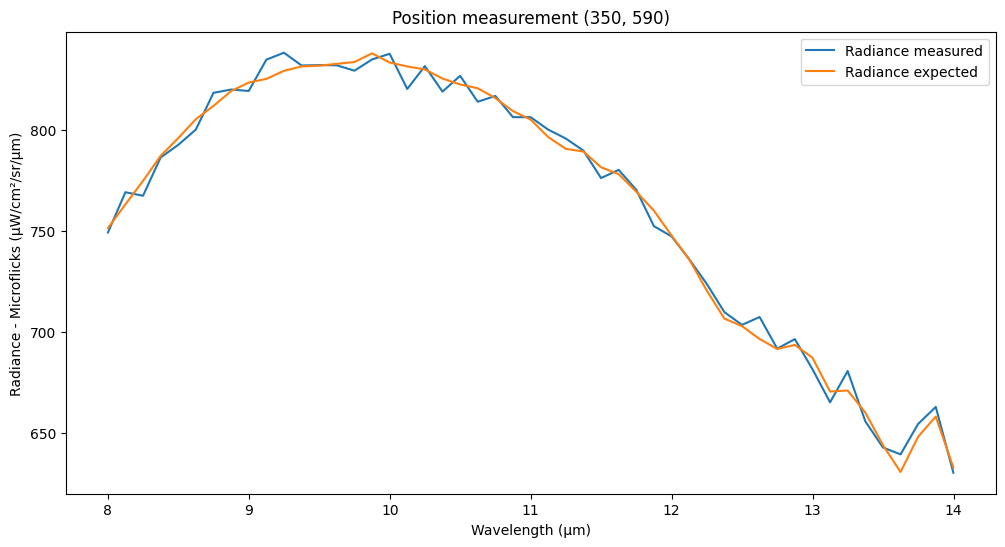

In [ ]:
I_real = add_noise(I, noise_level=None) #I es la radiancia esperada e I_real es la radiancia medida

plt.figure(figsize=(12,6))
plt.plot(wavelength,I_real, label='Radiance measured')
plt.plot(wavelength, I, label='Radiance expected')
plt.legend()
plt.xlabel('Wavelength (μm)')
plt.ylabel('Radiance - Microflicks (μW/cm²/sr/μm)')

plt.title(f'Position measurement ({pixelX}, {pixelY})')
plt.show()

In [16]:
def RMSE(measurement, expected):
    """
    Calculate the Root Mean Square Error (RMSE) between two signals.
    """
    return np.sqrt(np.mean((measurement - expected)**2))

In [17]:
def MAE(measurement, expected):
    """
    Calculate the Mean Absolute Error (MAE) between two signals.
    """
    return np.mean(np.absolute(measurement - expected))

In [18]:
# Calcula el RMSE
rmse = RMSE(I_real, I)

# Calcula el MAE
mae = MAE(I_real, I)

# Imprime los errores
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')


NameError: name 'I_real' is not defined

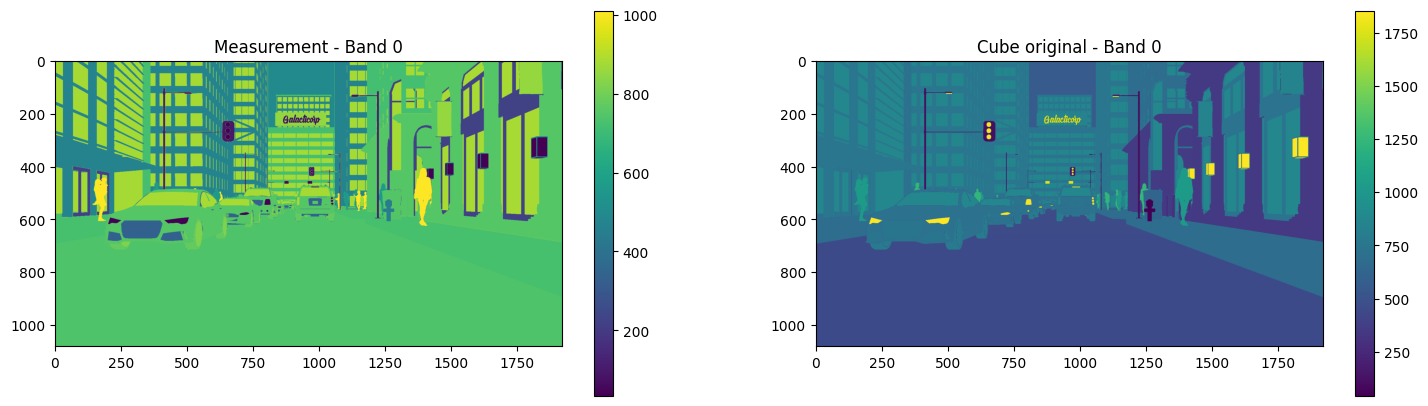

In [ ]:
T_air = 288 # temperatura del aire
T_scene = temperature_map + 273.15 # temperatura de la escena (convertir de Celsius a Kelvin)

## medición de la escena completa
# files attenuation:
# air
# enclosure
# CH4
# CO2
# H2O
# O3
measurement = forward_model(lambda_start, lambda_stop, T_air, depth_map, T_scene, emissivity_map, attenuation_file= None)

# cargar el cubo real
cube_original = np.load('data/L_0001_heatcube_sim.npy').transpose(2, 0, 1)

band = 0

plt.figure(figsize=(18,5))
plt.subplot(1, 2, 1)
plt.title('Measurement - Band {}'.format(band))
plt.imshow(measurement[band], cmap='viridis')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title('Cube original - Band {}'.format(band))
plt.imshow(cube_original[band], cmap='viridis')
plt.colorbar()

plt.show()

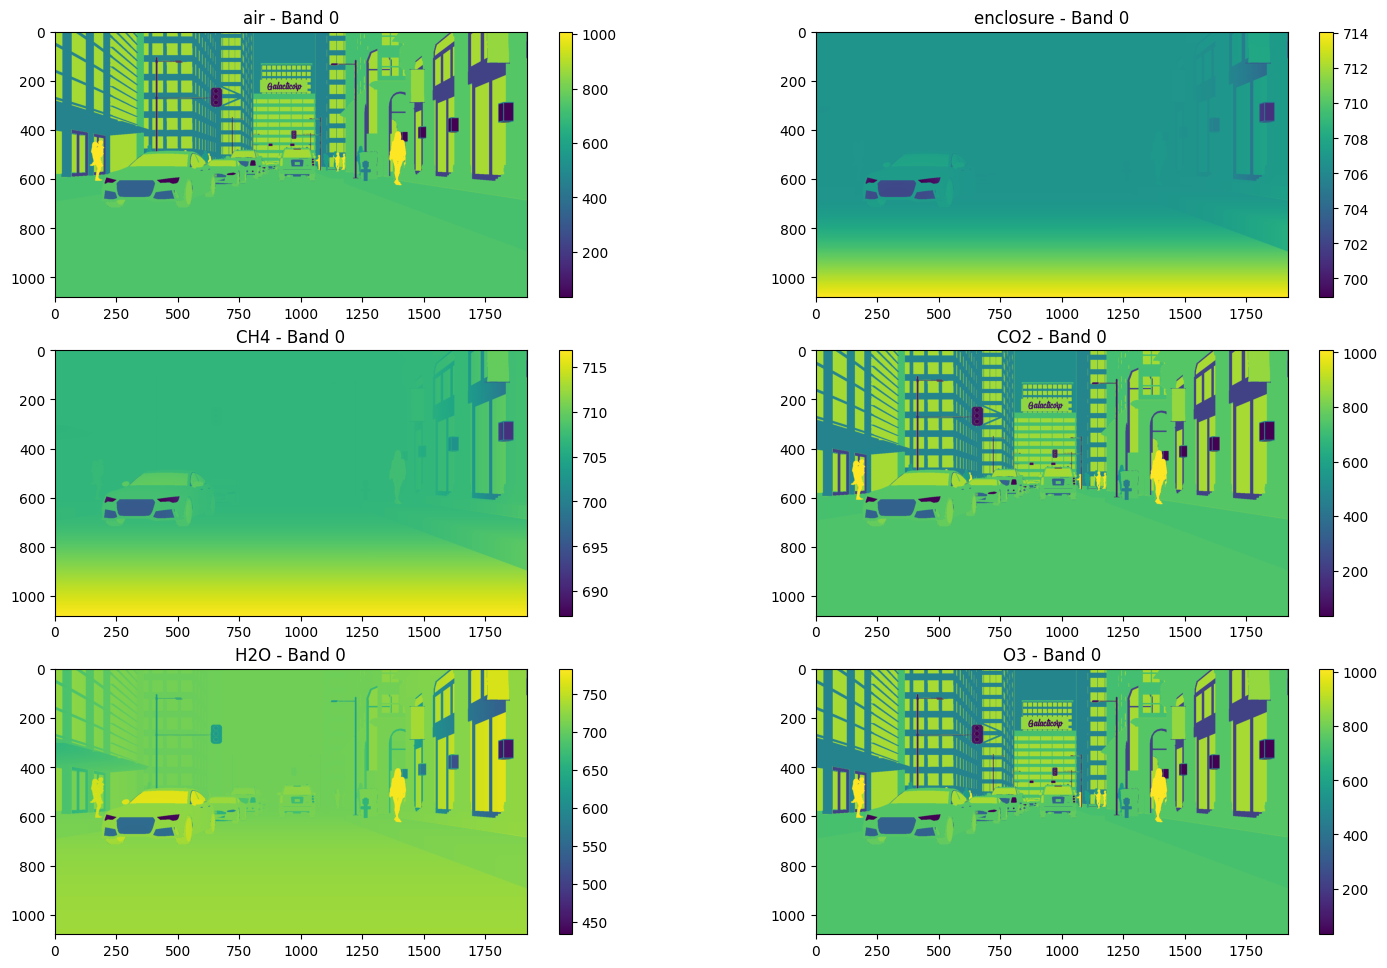